In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import random

# random seed for reproducibility
np.random.seed(42)
random.seed(42)

class Agent:
    """Represents an agent with a belief system."""
    def __init__(self, name, prior, bias, update_rule="bayesian"):
        self.name = name
        self.prior = prior
        self.bias = bias
        self.update_rule = update_rule
        self.evidence_log = []  # Log to store evidence impact

    def update_belief(self, evidence):
        """Update the agent's belief based on evidence."""
        prior_before = self.prior
        if self.update_rule == "bayesian":
            likelihood_safe = evidence["likelihood_safe"]
            likelihood_unsafe = evidence["likelihood_unsafe"]
            self.prior = (
                self.prior * likelihood_safe
                / (self.prior * likelihood_safe + (1 - self.prior) * likelihood_unsafe)
            )
        else:
            raise NotImplementedError("Only Bayesian updates are supported currently.")

        # Log evidence and its impact
        belief_change = abs(self.prior - prior_before)
        self.evidence_log.append({'evidence_type': evidence['type'], 'impact': belief_change})

        return self.prior

class Evidence:
    """Represents a piece of evidence."""
    def __init__(self, topic, polarity, credibility, likelihood_safe, likelihood_unsafe, evidence_type):
        self.topic = topic
        self.polarity = polarity
        self.credibility = credibility
        self.likelihood_safe = likelihood_safe
        self.likelihood_unsafe = likelihood_unsafe
        self.type = evidence_type

class AgentNetwork:
    """Represents a network of agents and their influence on each other."""
    def __init__(self):
        self.graph = nx.DiGraph()

    def add_agent(self, agent):
        self.graph.add_node(agent.name, agent=agent)

    def add_influence(self, source_name, target_name, weight):
        self.graph.add_edge(source_name, target_name, weight=weight)

    def update_beliefs(self, evidence):
        """Update beliefs of all agents, considering direct evidence and peer influence."""
        for agent_name in self.graph.nodes:
            agent = self.graph.nodes[agent_name]['agent']
            # Direct evidence update
            updated_belief = agent.update_belief({
                "likelihood_safe": evidence.likelihood_safe,
                "likelihood_unsafe": evidence.likelihood_unsafe,
                "type": evidence.type
            })

            # Peer influence update
            for neighbor in self.graph.predecessors(agent_name):
                influence_weight = self.graph[neighbor][agent_name]['weight']
                neighbor_belief = self.graph.nodes[neighbor]['agent'].prior
                updated_belief += influence_weight * (neighbor_belief - agent.prior)

            # Update the agent's prior
            agent.prior = min(max(updated_belief, 0), 1)  # Keep within [0, 1]

    def analyze_evidence_impact(self):
        """Analyze the cumulative impact of evidence types on agents' beliefs."""
        evidence_impact = {}
        for agent_name in self.graph.nodes:
            agent = self.graph.nodes[agent_name]['agent']
            for log_entry in agent.evidence_log:
                evidence_type = log_entry['evidence_type']
                impact = log_entry['impact']
                if evidence_type not in evidence_impact:
                    evidence_impact[evidence_type] = 0
                evidence_impact[evidence_type] += impact
        return evidence_impact

In [2]:
# Preprocess Data for Evidence
def preprocess_data(fake_file, real_file):
    fake_claims = pd.read_csv(fake_file)
    real_claims = pd.read_csv(real_file)

    fake_claims['label'] = 0
    real_claims['label'] = 1
    claims = pd.concat([fake_claims, real_claims])

    # Extract features using TF-IDF
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(claims['title'])

    # Assign polarity and credibility
    claims['polarity'] = claims['label'].apply(lambda x: "positive" if x == 1 else "negative")
    claims['credibility'] = tfidf_matrix.mean(axis=1).A.flatten()

    return claims

# Plot Evidence Impact
def plot_evidence_impact(impact_dict):
    evidence_types = list(impact_dict.keys())
    impact_values = list(impact_dict.values())
    plt.bar(evidence_types, impact_values, color=['blue', 'orange'])
    plt.title("Cumulative Evidence Impact on Agent Beliefs")
    plt.xlabel("Evidence Type")
    plt.ylabel("Cumulative Belief Change")
    plt.show()

# Simulation
def run_simulation(fake_file, real_file, steps=200, num_agents=10):
    # Preprocess data
    claims = preprocess_data(fake_file, real_file)

    # Create agents and network
    agents = [Agent(f"Agent_{i}", prior=np.random.uniform(0.1, 0.9), bias=np.random.uniform(0.1, 0.9)) for i in range(num_agents)]
    network = AgentNetwork()
    for agent in agents:
        network.add_agent(agent)
    
    # Add random influence edges
    for _ in range(num_agents * 2):
        source, target = random.sample(agents, 2)
        network.add_influence(source.name, target.name, weight=np.random.uniform(0.1, 0.5))

    # Create evidence pool
    evidence_pool = []
    for _, row in claims.iterrows():
        evidence_pool.append(Evidence(
            topic=row['title'],
            polarity=row['polarity'],
            credibility=row['credibility'],
            likelihood_safe=np.random.uniform(0.5, 1.0),
            likelihood_unsafe=np.random.uniform(0.0, 0.5),
            evidence_type="real" if row['label'] == 1 else "fake"
        ))

    # Run simulation
    for step in range(steps):
        evidence = random.choice(evidence_pool)
        network.update_beliefs(evidence)

    # Analyze and plot evidence impact
    evidence_impact = network.analyze_evidence_impact()
    plot_evidence_impact(evidence_impact)

In [3]:
path = '05-01-2020/'
fake_csv = path + "ClaimFakeCOVID-19.csv"
real_csv = path + "ClaimRealCOVID-19.csv"

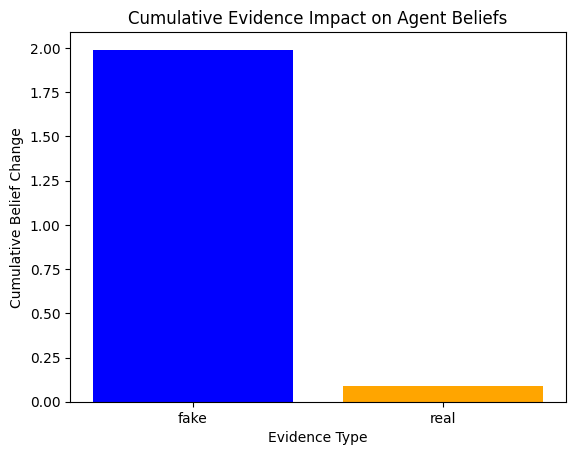

In [4]:
run_simulation(fake_csv, real_csv, 200, 3)

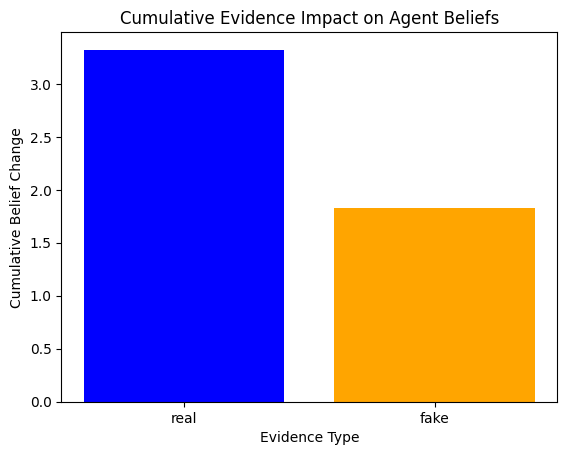

In [5]:
run_simulation(fake_csv, real_csv, 200, 7)

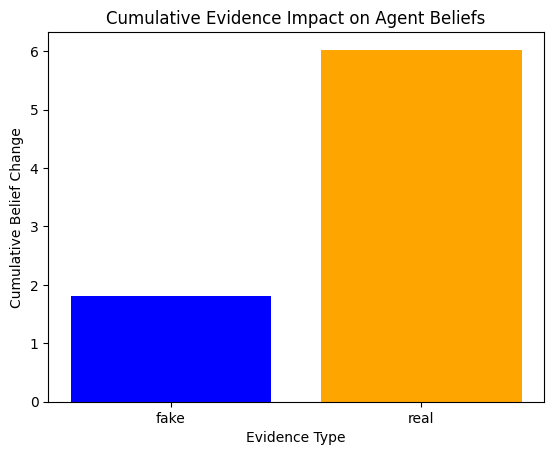

In [6]:
run_simulation(fake_csv, real_csv, 200, 10)

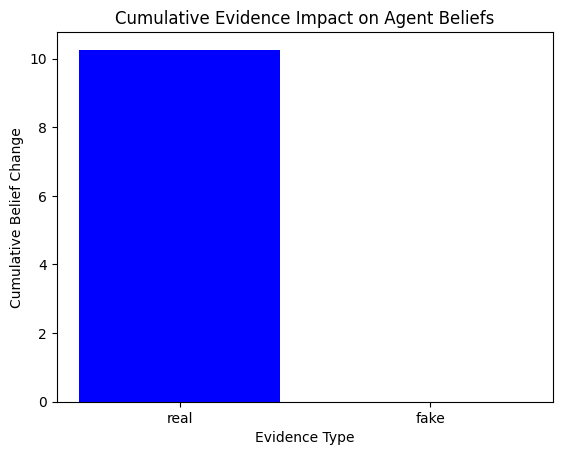

In [7]:
run_simulation(fake_csv, real_csv, 200, 15)

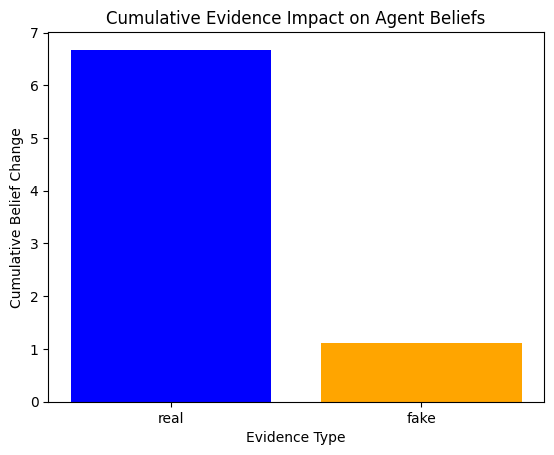

In [8]:
run_simulation(fake_csv, real_csv, 200, 13)

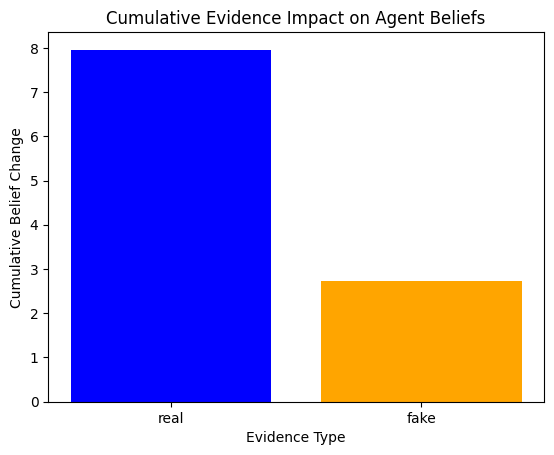

In [9]:
run_simulation(fake_csv, real_csv, 200, 17)